In [121]:
import numpy as np
import matplotlib.pyplot as plt

## Generate sinc function

In [122]:
def sinc(x):
    return np.sinc(x)

## Generate dataset

In [123]:
x = np.linspace(-10, 10, 1000)
y_true = sinc(x)

# Creating sequential datasets for training
seq_length = 50
dataX = []
dataY = []
for i in range(len(y_true) - seq_length):
    seq_in = y_true[i:i + seq_length]
    seq_out = y_true[i + seq_length]
    dataX.append(seq_in)
    dataY.append(seq_out)

# Converting to numpy arrays
dataX = np.array(dataX)
dataY = np.array(dataY)

# Splitting the data into training and testing sets
split_idx = int(0.8 * len(dataX))
X_train, X_test = dataX[:split_idx], dataX[split_idx:]
y_train, y_test = dataY[:split_idx], dataY[split_idx:]


In [124]:
def xavier_init(size):
  in_dim , out_dim = size
  xavier_lim = np.sqrt(6. / (in_dim + out_dim))
  return np.random.uniform(-xavier_lim, xavier_lim, size)

## RNN Model

Epoch 0, Loss: 0.06424834616534804
Epoch 1, Loss: 0.0649722388994439
Epoch 2, Loss: 0.0657765139320585
Epoch 3, Loss: 0.06647359900963065
Epoch 4, Loss: 0.06703473186011276
Epoch 5, Loss: 0.06738965543919755
Epoch 6, Loss: 0.06761097297778754
Epoch 7, Loss: 0.06760072421981055
Epoch 8, Loss: 0.06743037113466567
Epoch 9, Loss: 0.0671700683531386
Epoch 10, Loss: 0.06682834813945894
Epoch 11, Loss: 0.06642105927927598
Epoch 12, Loss: 0.06597503171242497
Epoch 13, Loss: 0.0654414692782632
Epoch 14, Loss: 0.06483247396716348
Epoch 15, Loss: 0.06417967932861354
Epoch 16, Loss: 0.06352922887959578
Epoch 17, Loss: 0.06290674009625144
Epoch 18, Loss: 0.06233963306211807
Epoch 19, Loss: 0.06167535100777825
Epoch 20, Loss: 0.060961678348065075
Epoch 21, Loss: 0.06019031317739063
Epoch 22, Loss: 0.05933563153421124
Epoch 23, Loss: 0.05840604661376359
Epoch 24, Loss: 0.057432663184922426
Epoch 25, Loss: 0.05643847312741047
Epoch 26, Loss: 0.055491464703976555
Epoch 27, Loss: 0.05460574011973969
Epo

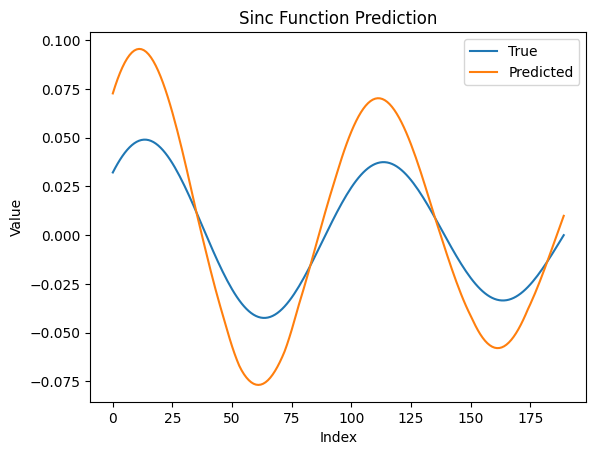

In [139]:
# Define RNN parameters
input_size = 1
hidden_size = 10
output_size = 1
learning_rate = 0.0001
seq_length = 10  # assuming you have a seq_length defined somewhere

# Initialize weights and biases
Wxh = xavier_init((hidden_size, input_size))
Whh = xavier_init((hidden_size, hidden_size))
Why = xavier_init((output_size, hidden_size))
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

# Define ReLU activation function
def relu(x):
    return np.maximum(-0.001*x, x)

def drelu(x):
    dx = np.ones_like(x)
    dx[x < 0] = -0.0001
    return dx


# Define forward pass function with ReLU activation
def forward_pass(inputs):
    hidden_states = []
    h_prev = np.zeros((hidden_size, 1))
    for t in range(seq_length):
        x_t = inputs[t].reshape(input_size, 1)
        h_t = relu(np.dot(Wxh, x_t) + np.dot(Whh, h_prev) + bh)
        hidden_states.append(h_t)
        h_prev = h_t
    output = np.dot(Why, hidden_states[-1]) + by
    return output, hidden_states

# Training parameters
epochs = 100

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i]
        target = y_train[i]

        # Forward pass
        output, hidden_states = forward_pass(inputs)

        # Compute loss
        loss = np.mean((output - target) ** 2)
        epoch_loss += loss

        # Backpropagation through time
        dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        dbh, dby = np.zeros_like(bh), np.zeros_like(by)
        dh_next = np.zeros_like(hidden_states[0])

        for t in reversed(range(seq_length)):
            dy = output - target
            dWhy += np.dot(dy, hidden_states[t].T)
            dby += dy
            dh = np.dot(Why.T, dy) + dh_next
            dh_raw = drelu(hidden_states[t]) * dh  # Derivative of ReLU
            dbh += dh_raw
            dWxh += np.dot(dh_raw, inputs[t].reshape(1, -1))
            dWhh += np.dot(dh_raw, hidden_states[t-1].T)
            dh_next = np.dot(Whh.T, dh_raw)

        # Update weights and biases with gradient clipping
        max_gradient_norm = 1.6

        # Clip gradients to avoid exploding gradients
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -max_gradient_norm, max_gradient_norm, out=dparam)

        # Update weights and biases
        Wxh -= learning_rate * dWxh
        Whh -= learning_rate * dWhh
        Why -= learning_rate * dWhy
        bh -= learning_rate * dbh
        by -= learning_rate * dby

    # Print average loss for the epoch
    epoch_loss /= len(X_train)
    print(f'Epoch {epoch}, Loss: {epoch_loss}')

# Predictions on test set
predictions = []
for i in range(len(X_test)):
    inputs = X_test[i]
    output, _ = forward_pass(inputs)
    predictions.append(output[0, 0])  # Flatten the output to a scalar value

# Plot original and predicted sinc function values
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.title('Sinc Function Prediction')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()
